# CampaignSense — EDA Orientada à Decisão

Este notebook executa a **análise exploratória orientada à decisão** da POC **CampaignSense**, com o objetivo de identificar **sinais relevantes de comportamento, engajamento e valor potencial dos clientes** que subsidiem as etapas de **modelagem de propensão** e **profit targeting**.

A análise é conduzida com foco exclusivo em **direcionamento técnico e de negócio**, sem antecipar decisões de modelagem ou políticas de contato.

---

## Contexto analítico

Após a preparação e o particionamento dos dados no Notebook 01, esta etapa tem como finalidade **explorar o conjunto de treino de forma direcionada**, concentrando-se apenas nos aspectos com impacto direto sobre decisões reais de campanha.

A EDA aqui apresentada é **instrumental**, orientada à leitura de sinal e à redução de incerteza, e não à exaustividade estatística ou exploração genérica dos dados.

Os resultados desta etapa servem como base para:
- priorização e descarte de variáveis;
- entendimento do desbalanceamento da base e suas implicações analíticas;
- definição de expectativas realistas para desempenho e comportamento dos modelos.

---

## Objetivo do notebook

- Reutilizar os datasets particionados (`train`, `valid`, `test`) definidos na etapa de preparação;
- Analisar a variável alvo sob a ótica de resposta e valor de negócio;
- Identificar padrões relevantes de comportamento, consumo e engajamento;
- Avaliar o potencial discriminativo das principais variáveis;
- Consolidar **insights acionáveis** para orientar a modelagem e a etapa decisória subsequente.

## 1. Setup e carregamento dos dados

In [1]:
# Governança: habilita import de módulos do projeto a partir de /notebooks
import sys
sys.path.insert(0, "..")

# Standard library
import json

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from matplotlib.ticker import MaxNLocator

# Local
from src.paths import PROCESSED_SPLIT_METADATA, PROCESSED_TRAIN


In [2]:
# Governança: seed global para reprodutibilidade do notebook
SEED = 42
np.random.seed(SEED)

# Configuração de exibição (não altera a persistência dos dados)
pd.set_option("display.float_format", "{:.4f}".format)
sns.set_theme(style="whitegrid", context="notebook")

In [3]:
# Carregamento do dataset traim
train = pd.read_parquet(PROCESSED_TRAIN)
print(f"Split train: {train.shape[0]} linhas x {train.shape[1]} colunas")

# Carregamento do metadata do particionamento
with open(PROCESSED_SPLIT_METADATA, "r", encoding="utf-8") as f:
    split_meta = json.load(f)

print(
    "Split meta | strategy:", split_meta.get("strategy"),
    "| seed:", split_meta.get("seed"),
    "| base_rate(train):", f'{split_meta["base_rate"]["train"]:.2%}'
)

Split train: 1431 linhas x 31 colunas
Split meta | strategy: stratified_random | seed: 42 | base_rate(train): 14.95%


## 2. Visão Geral da Variável Alvo

A distribuição da variável alvo `Response` é avaliada no **conjunto de treino** para estabelecer o **baseline do problema** e quantificar o grau de desbalanceamento antes de qualquer análise exploratória detalhada ou modelagem.

In [4]:
TARGET_COL = "Response"

target_dist = (
    train[TARGET_COL]
    .value_counts()
    .rename_axis("Response")
    .to_frame("count")
)

target_dist["proportion"] = target_dist["count"] / target_dist["count"].sum()

display(target_dist.style.format({"proportion": "{:.2%}"}))

,count,proportion
Response,,
0,1217,85.05%
1,214,14.95%


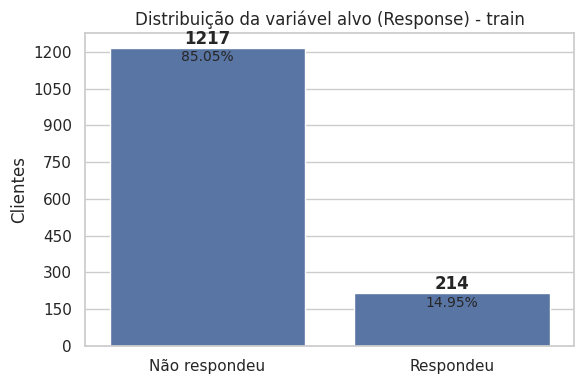

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(data=train, x=TARGET_COL, ax=ax)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Não respondeu", "Respondeu"])

# Força eixo Y com inteiros "crus"
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

counts = train[TARGET_COL].value_counts().sort_index()
props  = train[TARGET_COL].value_counts(normalize=True).sort_index()

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    weight="bold",
    labels=[f"{v:d}" for v in counts.values],
)

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    labels=[f"{v:.2%}" for v in props.values],
    padding=-12,
    fontsize=10,
)

ax.set_title("Distribuição da variável alvo (Response) - train")
ax.set_xlabel("")
ax.set_ylabel("Clientes")

plt.tight_layout()
plt.show()

No conjunto de treino, a variável `Response` apresenta a seguinte distribuição:

- **Não respondeu (0)**: 1.217 clientes (**85,05%**)
- **Respondeu (1)**: 214 clientes (**14,95%**)

Essa configuração caracteriza um **problema moderadamente desbalanceado**, típico de campanhas de marketing, e estabelece o **baseline analítico** para interpretação dos sinais explorados nas seções seguintes.  
Nenhuma ação corretiva é aplicada neste estágio.

## 3. Análise de Variáveis Demográficas

Nesta seção são avaliadas variáveis demográficas e familiares com o objetivo de **qualificar o sinal associado à resposta à campanha**, fornecendo direcionamento para as etapas subsequentes de modelagem e segmentação.

### 3.1. `Age`

In [6]:
# Age vs Response
age_summary = train.groupby("Response")["Age"].describe().T
display(age_summary)



Response,0,1
count,1217.0000,214.0000
mean,45.2408,44.5280
std,11.6003,11.8705
min,18.0000,18.0000
25%,37.0000,35.2500
50%,44.0000,43.0000
75%,55.0000,53.0000
max,73.0000,71.0000


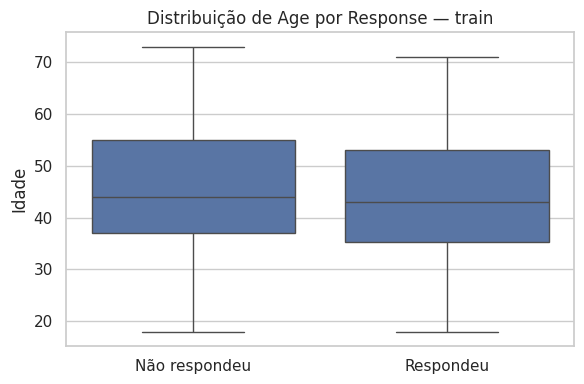

In [7]:
# Distribuição de Age por Response (train)
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=train,
    x="Response",
    y="Age",
    showfliers=False
)

plt.xticks([0, 1], ["Não respondeu", "Respondeu"])
plt.title("Distribuição de Age por Response — train")
plt.xlabel("")
plt.ylabel("Idade")

plt.tight_layout()
plt.show()

Clientes que responderam positivamente à campanha apresentam, em média, idade ligeiramente inferior à dos não respondentes (≈ 43,6 vs. 45,4 anos).

Apesar dessa diferença, as distribuições exibem **ampla sobreposição**, indicando que `Age` atua como **sinal fraco isoladamente**, com potencial apenas como variável complementar quando combinada a fatores comportamentais.

### 3.2. `Education`

In [8]:
edu_pivot = pd.crosstab(
    index=train["Education"],
    columns=train["Response"],
    normalize="index"
)

display(edu_pivot.style.format("{:.2%}"))

Response,0,1
Education,,
2n cycle,86.51%,13.49%
basic,94.87%,5.13%
graduation,86.57%,13.43%
master,86.86%,13.14%
phd,78.25%,21.75%


A taxa de resposta varia entre os níveis educacionais. Categorias como **PhD** apresentam taxas superiores à média global, enquanto **Basic** apresenta taxas inferiores.

Essas diferenças indicam **heterogeneidade de resposta por perfil educacional**, com potencial de exploração futura em conjunto com variáveis de comportamento e engajamento.

### 3.3. `Marital_Status`

In [9]:
marital_pivot = pd.crosstab(
    index=train["Marital_Status"],
    columns=train["Response"],
    normalize="index"
)

display(marital_pivot.style.format("{:.2%}"))

Response,0,1
Marital_Status,,
absurd,100.00%,0.00%
alone,66.67%,33.33%
divorced,78.81%,21.19%
married,87.21%,12.79%
single,80.07%,19.93%
together,89.70%,10.30%
widow,77.27%,22.73%
yolo,50.00%,50.00%


A taxa de resposta varia entre categorias de estado civil. Algumas classes apresentam **baixa cardinalidade** (`absurd`, `yolo`, `alone`), o que limita inferências isoladas neste estágio.

Essas categorias são mantidas sem reagrupamento nesta etapa, com eventual tratamento reservado para fases posteriores de segmentação.

## 4. Análise de Comportamento de Consumo

Esta seção avalia padrões de **consumo monetário** e **uso de canais de compra** associados à resposta à campanha, com foco em identificar **sinais relevantes para priorização e modelagem**.

A análise é conduzida exclusivamente no **conjunto de treino** e tem caráter **descritivo e orientado à decisão**, sem introdução de engenharia de atributos ou ações corretivas neste estágio.

### 4.1. Consumo agregado (TotalSpend)

Nesta etapa é construída uma métrica de **consumo agregado** (`TotalSpend`) com finalidade **exclusivamente analítica**, visando avaliar se o volume total de gasto discrimina clientes que responderam e não responderam à campanha.

A variável é derivada como a soma dos gastos por categoria e **não representa, neste estágio, uma decisão de feature engineering**.

In [10]:
# Consumo agregado (apenas para análise exploratória)
consumption_cols = [
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]

train["TotalSpend"] = train[consumption_cols].sum(axis=1)

train.groupby("Response")["TotalSpend"].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1217.0000,544.3188,553.5785,5.0000,63.0000,322.0000,960.0000,2525.0000
1,214.0000,1022.0234,718.2813,17.0000,255.2500,1156.5000,1653.7500,2524.0000


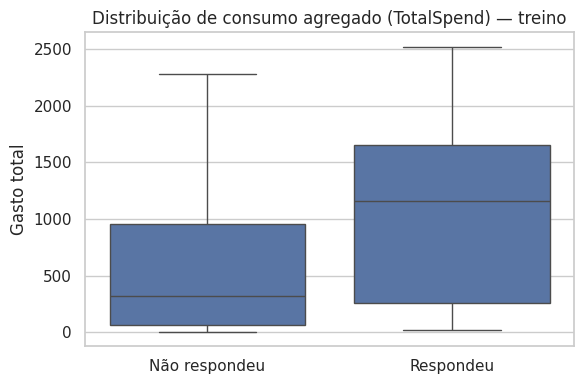

In [11]:
# Distribuição comparativa de consumo agregado (TotalSpend)
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=train,
    x="Response",
    y="TotalSpend",
    showfliers=False
)

plt.xticks([0, 1], ["Não respondeu", "Respondeu"])
plt.title("Distribuição de consumo agregado (TotalSpend) — treino")
plt.xlabel("")
plt.ylabel("Gasto total")

plt.tight_layout()
plt.show()

Clientes que responderam à campanha apresentam **níveis substancialmente mais elevados de consumo agregado**.

A **média** de gasto dos respondedores é aproximadamente o dobro da observada entre não respondedores, enquanto a **mediana** também se mantém significativamente superior (≈ 1.156 vs. 322), indicando que a diferença não é explicada apenas por poucos outliers.

A visualização confirma esse comportamento, evidenciando uma **separação consistente de nível central** entre os grupos, ainda que com sobreposição parcial.  
Esse padrão caracteriza `TotalSpend` como um **sinal monetário forte**, com elevado potencial discriminativo para modelagem de propensão e priorização orientada a valor.

### 4.2. Canais de compra × resposta

In [12]:
# Uso médio de canais de compra por resposta (train)
channel_cols = [
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
]

channel_means = train.groupby("Response")[channel_cols].mean()
display(channel_means)

,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
Response,,,
0,3.9482,2.3451,5.8242
1,5.0981,4.1215,6.0047


Clientes que **responderam à campanha** apresentam maior intensidade de compras via canais digitais, especialmente **web** e **catálogo**, em comparação aos não respondedores.

O canal de **loja física** apresenta diferença **marginal** entre os grupos, indicando menor poder discriminativo isolado.  
Esses resultados posicionam **canais digitais** como **sinais complementares relevantes**, enquanto o canal físico tende a contribuir de forma secundária no contexto da resposta à campanha.

### 4.3. Frequência de interação digital

In [13]:
# Frequência de visitas ao canal digital (NumWebVisitsMonth)
train.groupby("Response")["NumWebVisitsMonth"].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1217.0000,5.3615,2.4073,0.0000,4.0000,6.0000,7.0000,20.0000
1,214.0000,5.2430,2.5188,1.0000,3.0000,6.0000,7.7500,9.0000


A frequência de visitas ao canal digital apresenta **distribuições muito próximas** entre clientes que responderam e não responderam à campanha.

As estatísticas de posição central (média e mediana) são praticamente equivalentes entre os grupos, indicando que a **intensidade de navegação isoladamente não discrimina** a propensão à resposta.

Esse comportamento sugere que `NumWebVisitsMonth` possui **baixo poder discriminativo isolado**, podendo atuar apenas como variável complementar quando combinada a métricas de consumo ou engajamento efetivo.

### 4.4. Validação estatística pontual (Mann–Whitney)

Para validar de forma pontual os padrões observados na análise exploratória, é aplicado o teste **Mann–Whitney U** em um conjunto restrito de variáveis representativas.

O objetivo é verificar se as diferenças entre clientes que responderam e não responderam à campanha são **estatisticamente consistentes**, sem extrapolar para inferência causal ou seleção automática de variáveis.

In [14]:
def mw_test(col):
    g0 = train.loc[train["Response"] == 0, col]
    g1 = train.loc[train["Response"] == 1, col]
    stat, p = mannwhitneyu(g0, g1, alternative="two-sided")
    return p

for col in ["TotalSpend", "NumWebPurchases", "NumStorePurchases"]:
    print(col, mw_test(col))

TotalSpend 2.451961115496264e-21
NumWebPurchases 5.350697648820008e-11
NumStorePurchases 0.1379177522792703


Os resultados confirmam evidência estatística forte para diferenças associadas a **consumo agregado (`TotalSpend`)** e **compras via canal web (`NumWebPurchases`)**.

Por outro lado, não é observada evidência estatística significativa para **compras em loja física (`NumStorePurchases`)**, corroborando a leitura exploratória de que esse canal possui **poder discriminativo limitado** no contexto da resposta à campanha.

## 5. Análise de Engajamento e Histórico de Campanhas

Esta seção analisa variáveis relacionadas à **recência de compra** e ao **histórico de engajamento em campanhas anteriores**, com o objetivo de identificar sinais associados à resposta atual e avaliar sua relevância para modelagem de propensão.

### 5.1. Recência de compra (Recency)

In [15]:
train.groupby("Response")["Recency"].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1217.0000,51.6574,28.3878,0.0000,28.0000,52.0000,77.0000,99.0000
1,214.0000,35.5234,28.4786,0.0000,11.0000,27.0000,60.0000,99.0000


Clientes que responderam à campanha apresentam **compras mais recentes** em comparação aos que não responderam, refletido por médias e medianas inferiores da variável `Recency`.

Apesar da diferença clara de nível central, observa-se sobreposição relevante entre as distribuições, indicando que a recência atua como **sinal relevante**, porém **não dominante** quando considerada isoladamente.

### 5.2 Histórico de campanhas anteriores (AcceptedCmp*)

In [16]:
accepted_cols = [
    "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3",
    "AcceptedCmp4", "AcceptedCmp5"
]

train.groupby("Response")[accepted_cols].mean()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5
Response,,,,,
0,0.0304,0.0049,0.0485,0.0526,0.0370
1,0.2477,0.0701,0.2477,0.1916,0.3037


O histórico de aceitação de campanhas anteriores apresenta **diferença substancial e consistente** entre os grupos.

Em todas as campanhas avaliadas, clientes que responderam à campanha atual exibem **taxas de aceitação significativamente superiores**, indicando um padrão robusto de engajamento recorrente.

Esse comportamento caracteriza as variáveis `AcceptedCmp*` como **sinais fortemente associados à resposta**, com elevado poder discriminativo no contexto de CRM Analytics.

### 5.3. Engajamento agregado em campanhas (AcceptedCmpTotal)

In [17]:
train["AcceptedCmpTotal"] = train[accepted_cols].sum(axis=1)

train.groupby("Response")["AcceptedCmpTotal"].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1217.0000,0.1734,0.4716,0.0000,0.0000,0.0000,0.0000,4.0000
1,214.0000,1.0607,1.1511,0.0000,0.0000,1.0000,2.0000,4.0000


A variável agregada `AcceptedCmpTotal` evidencia uma **separação clara** entre os grupos.

Enquanto a maioria dos clientes que não responderam à campanha apresenta histórico nulo de aceitação, clientes que responderam concentram-se em valores positivos, com **média superior a 1 campanha aceita**.

Esse resultado consolida o **histórico de engajamento em campanhas** como **um dos principais drivers associados à resposta**, superando variáveis demográficas e comportamentais isoladas.

### Registro crítico — Engajamento histórico

O conjunto de variáveis relacionadas a campanhas anteriores apresenta **sinal preditivo extremamente forte**.

Esse tipo de sinal, embora altamente informativo, requer **tratamento criterioso na modelagem**, pois tende a dominar modelos de propensão se não houver controle adequado, podendo mascarar a contribuição de variáveis comportamentais e monetárias.

Esse risco é registrado nesta etapa e será endereçado explicitamente no notebook de modelagem.

## 6. Análise univariada orientada à resposta

Nesta seção, os principais achados da análise exploratória são consolidados sob a ótica **univariada**, com o objetivo de **confirmar a hierarquia de sinal** das variáveis mais relevantes em relação à resposta à campanha.

Não são introduzidas novas análises ou transformações. O foco é **organizar e sintetizar evidências já observadas**, preparando o direcionamento para a etapa de modelagem.

A análise univariada confirma a hierarquia de sinal observada entre as variáveis avaliadas:

- **`TotalSpend`**  
  Apresenta forte poder discriminativo, com diferença substancial de nível central entre clientes que responderam e não responderam à campanha. Configura-se como o principal **sinal monetário** da POC.

- **`AcceptedCmpTotal`**  
  Evidencia separação clara entre os grupos, consolidando o **histórico de engajamento em campanhas anteriores** como um dos **drivers mais fortes** associados à resposta.

- **`Recency`**  
  Clientes que responderam tendem a apresentar compras mais recentes. O sinal é consistente, porém menos dominante quando comparado a consumo agregado e histórico de campanha.

- **`NumWebPurchases`**  
  Atua como **sinal complementar**, reforçando a relevância do canal digital, especialmente quando combinado a métricas de consumo.

- **`Age`**  
  Apesar de pequenas diferenças de média entre os grupos, as distribuições apresentam ampla sobreposição, caracterizando `Age` como **sinal fraco isoladamente**.

Essas variáveis não são descartadas neste estágio, mas seu valor analítico tende a emergir apenas em **interação com variáveis comportamentais ou de engajamento**.

In [18]:
cols_summary = [
    "TotalSpend",
    "AcceptedCmpTotal",
    "Recency",
    "NumWebPurchases",
    "Age",
]

summary_by_group = train.groupby("Response")[cols_summary].describe().T
display(summary_by_group)

Response                       0         1
TotalSpend       count 1217.0000  214.0000
                 mean   544.3188 1022.0234
                 std    553.5785  718.2813
                 min      5.0000   17.0000
                 25%     63.0000  255.2500
                 50%    322.0000 1156.5000
                 75%    960.0000 1653.7500
                 max   2525.0000 2524.0000
AcceptedCmpTotal count 1217.0000  214.0000
                 mean     0.1734    1.0607
                 std      0.4716    1.1511
                 min      0.0000    0.0000
                 25%      0.0000    0.0000
                 50%      0.0000    1.0000
                 75%      0.0000    2.0000
                 max      4.0000    4.0000
Recency          count 1217.0000  214.0000
                 mean    51.6574   35.5234
                 std     28.3878   28.4786
                 min      0.0000    0.0000
                 25%     28.0000   11.0000
                 50%     52.0000   27.0000
                 75%     77.0000   60.0000
                 max     99.0000   99.0000
NumWebPurchases  count 1217.0000  214.0000
                 mean     3.9482    5.0981
                 std      2.7610    2.5518
                 min      0.0000    0.0000
                 25%      2.0000    3.0000
                 50%      3.0000    5.0000
                 75%      6.0000    7.0000
                 max     27.0000   11.0000
Age              count 1217.0000  214.0000
                 mean    45.2408   44.5280
                 std     11.6003   11.8705
                 min     18.0000   18.0000
                 25%     37.0000   35.2500
                 50%     44.0000   43.0000
                 75%     55.0000   53.0000
                 max     73.0000   71.0000

### Síntese da análise univariada

A análise univariada orientada à resposta confirma **diferenças consistentes** entre clientes que responderam e não responderam à campanha nas variáveis centrais do problema.

O **consumo agregado (`TotalSpend`)** e o **histórico de aceitação de campanhas (`AcceptedCmpTotal`)** apresentam a separação mais pronunciada entre os grupos, consolidando-se como os **principais drivers associados à resposta**. A **recência de compra** reforça esse padrão como sinal relevante, embora menos dominante.

Variáveis relacionadas ao **canal digital**, como `NumWebPurchases`, atuam como **sinais complementares**, enquanto características demográficas, como `Age`, exibem **baixo poder discriminativo isolado**.

Essa consolidação orienta a priorização de variáveis comportamentais e de engajamento histórico nas etapas subsequentes de modelagem, mantendo alinhamento direto com o objetivo de **profit targeting** da POC CampaignSense.

## 7. Consolidação multivariada e direcionamento para modelagem

Nesta seção, os achados da análise exploratória são consolidados sob uma perspectiva multivariada, com o objetivo de **reforçar a hierarquia de sinal** e **orientar decisões de modelagem**.

A análise não introduz novos sinais, mas valida a consistência dos padrões observados nas etapas univariadas.

### 7.1. Correlação com a variável alvo
A correlação entre as variáveis numéricas e a variável alvo confirma que os maiores níveis de associação estão concentrados em:

- **Histórico de campanhas** (`AcceptedCmpTotal` e `AcceptedCmp*`);
- **Consumo monetário**, tanto agregado (`TotalSpend`) quanto por categorias;
- **Recência de compra**, com correlação negativa consistente.

Variáveis demográficas e de frequência de visita apresentam correlação marginal, reforçando seu papel secundário no problema.

In [19]:
# Correlação com a variável alvo (Response)
corr_target = (
    train.select_dtypes(include="number")
    .corr()["Response"]
    #.dropna()
    .sort_values(ascending=False)
)

corr_target_df = corr_target.to_frame("corr_with_response")
display(corr_target_df)

,corr_with_response
Response,1.0000
AcceptedCmpTotal,0.4538
AcceptedCmp5,0.3571
AcceptedCmp1,0.3192
TotalSpend,0.2815
MntWines,0.2692
AcceptedCmp3,0.2645
MntMeatProducts,0.2406
NumCatalogPurchases,0.2321
TenureDays,0.1965


### 7.2. Redundância e colinearidade

Observa-se **alta colinearidade entre variáveis monetárias**, especialmente entre o consumo total e os gastos por categoria.

Essa redundância indica que essas variáveis capturam essencialmente o mesmo comportamento subjacente, exigindo cautela na inclusão simultânea dessas informações na modelagem.

In [20]:
cols_spend = ["TotalSpend", "MntWines", "MntMeatProducts", "MntGoldProds"]

corr_spend = train[cols_spend].corr()

display(corr_spend)

,TotalSpend,MntWines,MntMeatProducts,MntGoldProds
TotalSpend,1.0000,0.8924,0.8443,0.5194
MntWines,0.8924,1.0000,0.5638,0.3758
MntMeatProducts,0.8443,0.5638,1.0000,0.3597
MntGoldProds,0.5194,0.3758,0.3597,1.0000


### 7.3. Direcionamento para modelagem

Com base nas análises realizadas, o direcionamento para a etapa de modelagem é claro:

- O **histórico de campanhas** configura-se como o **driver mais forte** associado à resposta;
- O **consumo agregado** representa o principal sinal monetário;
- Variáveis como **recência** e **canal digital** atuam como sinais relevantes ou complementares;
- Variáveis demográficas e operacionais possuem **baixo poder discriminativo isolado**.

Adicionalmente, o forte sinal associado ao histórico de campanhas e a colinearidade monetária indicam a necessidade de **controle cuidadoso na modelagem**, priorizando interpretabilidade, estabilidade e impacto financeiro.

## Encerramento

Este notebook consolidou os **principais achados exploratórios da POC CampaignSense**, com foco em apoiar decisões analíticas orientadas a valor. Ao longo da análise, foram abordados:

- a distribuição e o desbalanceamento da variável alvo;
- o comportamento de consumo e o uso de canais de compra;
- o engajamento e o histórico de campanhas anteriores;
- comparações univariadas entre clientes que responderam e não responderam à campanha;
- uma análise multivariada exploratória leve, voltada à identificação de correlações e redundâncias;
- a síntese estruturada de variáveis com sinal forte, complementar e baixo sinal, bem como alertas relevantes para a modelagem.

Os resultados obtidos encerram a etapa exploratória e fornecem **direcionamento claro para a fase de segmentação e modelagem de propensão**, assegurando que as decisões subsequentes sejam fundamentadas em sinais consistentes, interpretáveis e alinhados ao objetivo de **profit targeting** da POC.